# Fig 7

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances, pairwise_distances
from scipy.spatial import distance
from scipy.cluster import hierarchy
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from sklearn.neighbors import NearestNeighbors
from umap import UMAP
import matplotlib
from sklearn.manifold import trustworthiness
import matplotlib.colors as colors
from sklearn.metrics import adjusted_mutual_info_score
import matplotlib.cm as cmx
from scipy import stats


In [5]:
one_hot_embedding_path = "../data/20240812_175_org_one_hot.csv"
esm_650M_layer_33_path = "../data/20240201_adk_esm_650M_layer33_updated.csv"
msa_kcat_path = "../data/20240812_adk_msa_temp.csv"
full_dataset_path = "../data/adk_ortholog_dataset_km_filtered.csv"

In [6]:
full_msa_df = pd.read_csv(msa_kcat_path, index_col=0)

In [7]:
dataset = pd.read_csv(full_dataset_path)

In [8]:
full_msa_df = dataset[["org_name", "kcat_mean_normed", "Km_mean_filtered"]].merge(full_msa_df, how="right", on="org_name") 
full_msa_df["seq_length"] = full_msa_df.apply(lambda x: sum(1 if i != "-" else 0 for i in x.values[4:-4]), axis=1)


In [9]:
full_msa_df

,org_name,kcat_mean_normed,Km_mean_filtered,0,1,2,3,4,5,6,...,494,495,496,497,498,c4_motif,temperature,lid_type,org_in_first_lib,seq_length
0,desulfovibrio_desulfuricans,NaN,NaN,-,-,-,-,-,-,-,...,-,-,-,-,-,CNCC,31,zinc-like,True,223
1,azorhizobium_caulinodans,20.287820,228.294494,-,-,-,-,-,-,-,...,-,-,-,-,-,EA--,30,lidless,True,194
2,methylocella_silvestris,123.061061,1066.598980,-,-,-,-,-,-,-,...,-,-,-,-,-,EA--,23,lidless,True,193
3,bartonella_henselae,77.856752,342.284019,-,-,-,-,-,-,-,...,-,-,-,-,-,EI--,37,lidless,True,192
4,sorangium_cellulosum,12.518474,216.297684,-,-,-,-,-,-,-,...,-,-,-,-,-,DS--,28,lidless,True,215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5140,zunongwangia_profunda,NaN,NaN,-,-,-,-,-,-,-,...,-,-,-,-,-,T---,28,lidless,False,190
5141,zymobacter_palmae,NaN,NaN,-,-,-,-,-,-,-,...,-,-,-,-,-,HSDT,26,hbond_like,False,218
5142,zymomonas_mobilis,NaN,NaN,-,-,-,-,-,-,-,...,-,-,-,-,-,CCCC,30,zinc-like,False,223
5143,mycoplasma_mobile,88.316547,460.223382,-,-,-,-,-,-,-,...,-,-,-,-,-,CCCH,26,zinc-like,True,217


# 3) ESM Prep

In [10]:
esm_df = pd.read_csv(esm_650M_layer_33_path, index_col=0)

In [11]:
# compute PCA on ESM embeddings
pca = PCA(n_components=2)
esm_pca = pca.fit_transform(esm_df.iloc[:, 1:])
esm_pca_df = pd.DataFrame(esm_pca, columns=["PC1", "PC2"])
esm_pca_df["org_name"] = esm_df["Organism"]

In [12]:
esm_joined_pca_df = full_msa_df.copy().drop(columns=[str(i) for i in list(range(0, 499))]).merge(esm_pca_df, how="right", on="org_name")

In [13]:
esm_joined_pca_df

,org_name,kcat_mean_normed,Km_mean_filtered,c4_motif,temperature,lid_type,org_in_first_lib,seq_length,PC1,PC2
0,acidaminobacter_hydrogenoformans,NaN,NaN,CCCC,30.0,zinc-like,False,216.0,-0.234700,0.319497
1,staphylococcus_arlettae,NaN,NaN,CCCD,35.0,zinc-like,False,216.0,-0.203641,0.546346
2,hoeflea_phototrophica,NaN,NaN,EA--,30.0,lidless,False,194.0,0.072325,-0.340412
3,cytobacillus_firmus,NaN,NaN,CCCC,30.0,zinc-like,False,216.0,-0.854364,0.306624
4,bifidobacterium_eulemuris,NaN,NaN,----,37.0,lidless,False,190.0,-0.233877,-0.406737
...,...,...,...,...,...,...,...,...,...,...
5146,selenomonas_artemidis,NaN,NaN,CCCC,40.0,zinc-like,False,214.0,-0.229832,-0.025460
5147,caulobacter_mirabilis,NaN,NaN,E---,33.0,lidless,False,190.0,0.469114,-0.499017
5148,mesoplasma_lactucae,NaN,NaN,CCCD,30.0,zinc-like,False,216.0,0.421528,0.889598
5149,prevotella_albensis,NaN,NaN,E---,37.0,lidless,False,192.0,-0.165200,0.196846


In [14]:
# run UMAP on ESM embeddings
umap = UMAP(n_components=2, random_state=314)
esm_umap = umap.fit_transform(esm_df.iloc[:, 1:])
esm_umap_df = pd.DataFrame(esm_umap, columns=["UMAP1", "UMAP2"])
esm_umap_df["org_name"] = esm_df["Organism"]

esm_joined_umap_df = full_msa_df.copy().drop(columns=[str(i) for i in list(range(0, 499))]).merge(esm_umap_df, how="right", on="org_name")

/home/dmuir/anaconda3/envs/htbam/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


# 4) PCA and UMAP
___

In [15]:
# drop NA in org_in_first_lib column
esm_joined_pca_df = esm_joined_pca_df.dropna(subset=["org_in_first_lib"])
esm_joined_umap_df = esm_joined_umap_df.dropna(subset=["org_in_first_lib"])

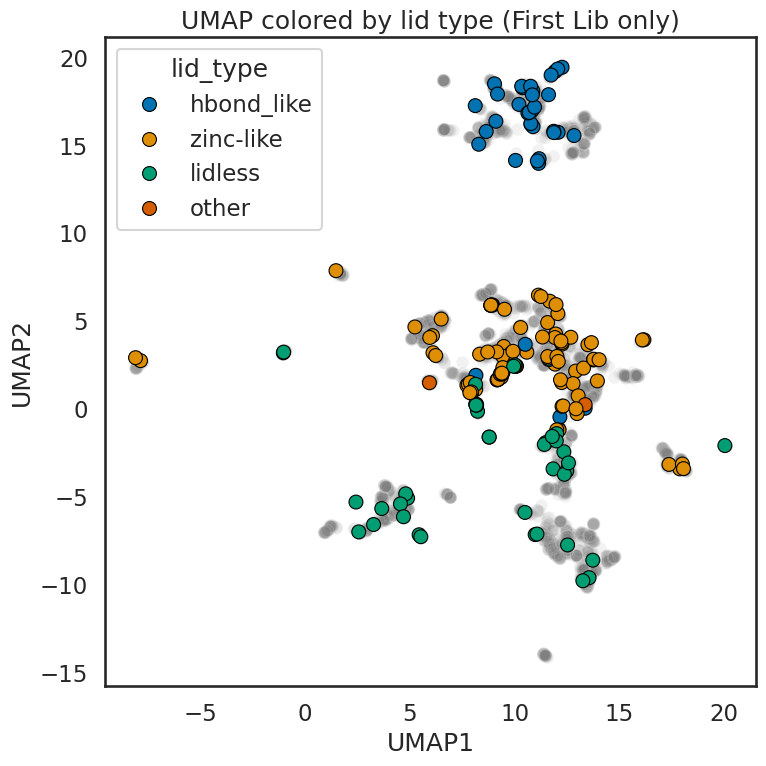

In [16]:
# same as above but grey out the non-first lib sequences
sns.set_context("talk")
sns.set_style("white")
sns.set_palette("colorblind")
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=esm_joined_umap_df, x="UMAP1", y="UMAP2", color="grey", ax=ax, alpha=0.1)
sns.scatterplot(data=esm_joined_umap_df[esm_joined_umap_df["org_in_first_lib"]], x="UMAP1", y="UMAP2", hue="lid_type", ax=ax, s=100, edgecolor="black")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_title("UMAP colored by lid type (First Lib only)")
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
plt.savefig("../data/fig_pdfs/lid_first_lib_umap_new.pdf")

In [17]:
#https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.
    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)
    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False),
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)
    return newcmap

In [153]:
# generate a blue to red colormap for temperature
temp_cmap = shiftedColorMap(cmx.coolwarm, midpoint=0.35, name="shifted_coolwarm1")

temp_normalize = plt.Normalize(vmin=esm_joined_umap_df["temperature"].min(), vmax=esm_joined_umap_df["temperature"].max())
temp_colors = [temp_cmap(temp_normalize(value)) for value in esm_joined_umap_df["temperature"]]
#first_lib_temp_colors = [temp_cmap(temp_normalize(value)) for value in esm_joined_umap_df[esm_joined_umap_df["org_in_first_lib"]]["temperature"]]

In [154]:
esm_joined_umap_df["temp_colors"] = temp_colors
esm_joined_pca_df["temp_colors"] = temp_colors

/tmp/ipykernel_9482/1196549752.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esm_joined_pca_df["temp_colors"] = temp_colors


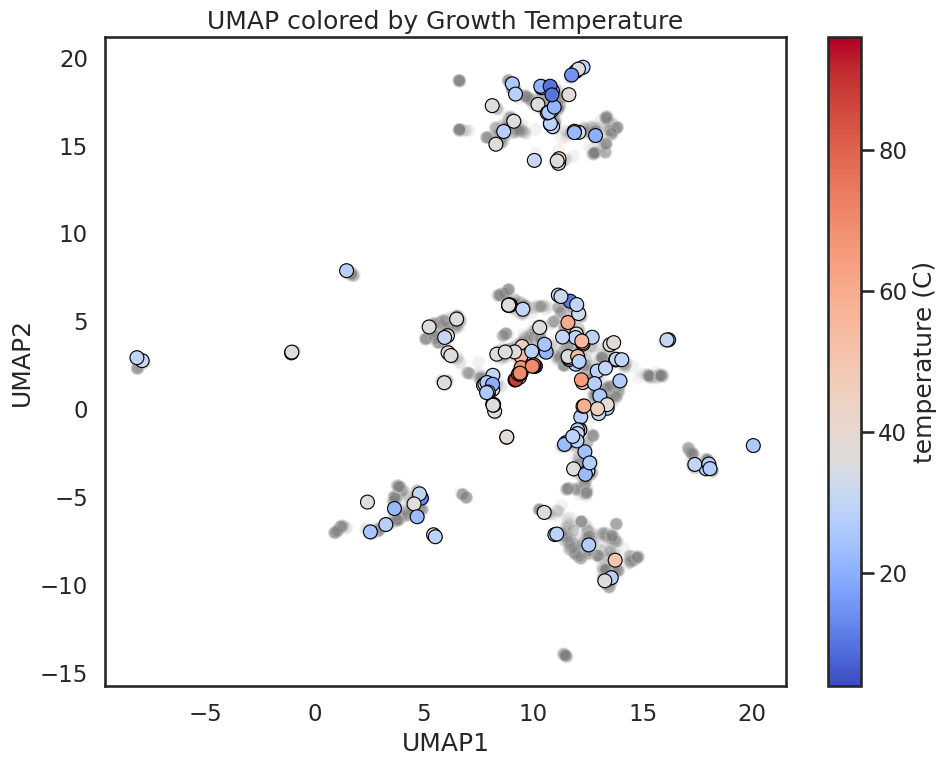

In [212]:
# same as above but grey out the non-first lib sequences
sns.set_context("talk")
sns.set_style("white")
sns.set_palette("colorblind")
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=esm_joined_umap_df, x="UMAP1", y="UMAP2", color="grey", ax=ax, alpha=0.1)
sns.scatterplot(data=esm_joined_umap_df[esm_joined_umap_df["org_in_first_lib"]], x="UMAP1", y="UMAP2", 
color=esm_joined_umap_df[esm_joined_umap_df["org_in_first_lib"]]["temp_colors"],
 ax=ax, s=100, edgecolor="black",
legend=False)
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_title("UMAP colored by Growth Temperature")
# add colorbar
sm = plt.cm.ScalarMappable(cmap=temp_cmap, norm=temp_normalize)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Growth Temperature (C)")
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
#plt.savefig("../data/fig_pdfs/umap_temp_first_lib.pdf")

In [275]:
kcat_cmap = matplotlib.colormaps["viridis"]
esm_joined_umap_df["log10_kcat"] = np.log10(esm_joined_umap_df["kcat_mean_normed"])
# kcat_normalize = plt.Normalize(vmin=esm_joined_umap_df["kcat_mean_filtered"].min(), vmax=esm_joined_umap_df["kcat_mean_filtered"].max())
# kcat_colors = [kcat_cmap(kcat_normalize(value)) for value in esm_joined_umap_df[~esm_joined_umap_df["kcat_mean_filtered"].isna()]["kcat_mean_filtered"]]
kcat_normalize = plt.Normalize(vmin=0, vmax=3)#esm_joined_umap_df["log10_kcat"].max())
kcat_colors = [kcat_cmap(kcat_normalize(value)) for value in esm_joined_umap_df[~esm_joined_umap_df["log10_kcat"].isna()]["log10_kcat"]]

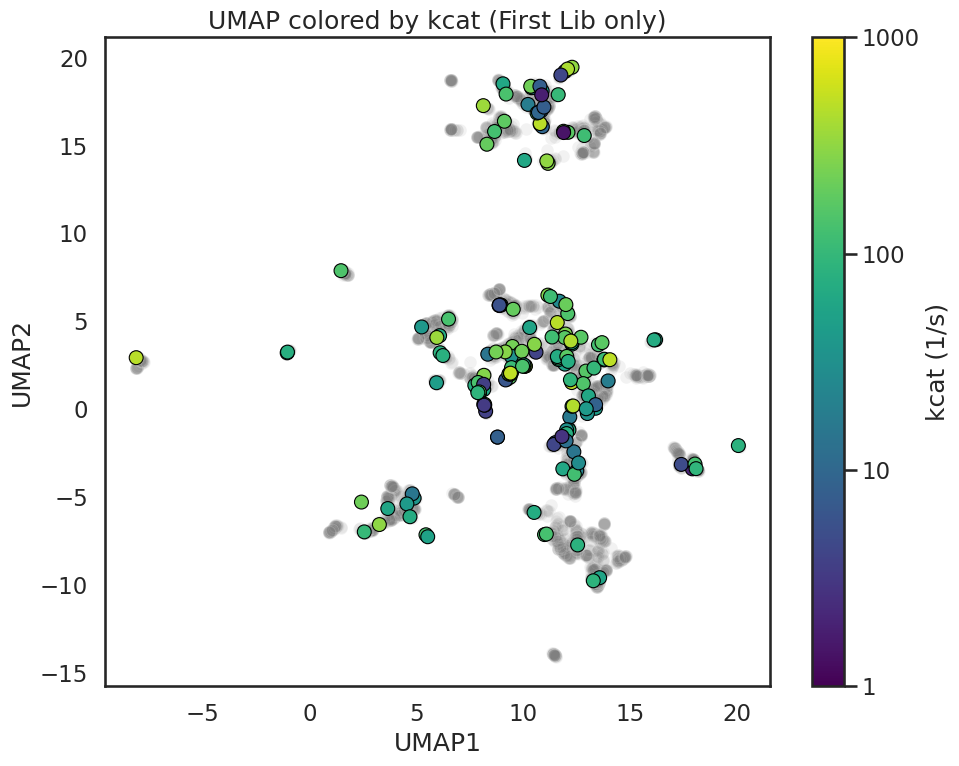

In [276]:
# same as above but grey out the non-first lib sequences and color by kcat, and use plasma colormap
sns.set_context("talk")
sns.set_style("white")
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=esm_joined_umap_df, x="UMAP1", y="UMAP2", color="grey", ax=ax, alpha=0.1)
sns.scatterplot(data=esm_joined_umap_df[~esm_joined_umap_df["log10_kcat"].isna()], x="UMAP1", y="UMAP2",
 ax=ax, s=100, edgecolor="black",
color=kcat_colors,    
legend=False)
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_title("UMAP colored by kcat (First Lib only)")
# add colorbar
sm = plt.cm.ScalarMappable(cmap=kcat_cmap, norm=kcat_normalize)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label="kcat (1/s)")
cbar.set_ticks([0,1, 2, 3])
ticks = cbar.get_ticks()
ticks = 10**ticks
cbar.set_ticklabels(ticks)
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
#plt.savefig("../data/fig_pdfs/kcat_first_lib_umap.pdf")


Text(0.5, 1.0, 'ESM-2 PCA colored by Lid-Type')

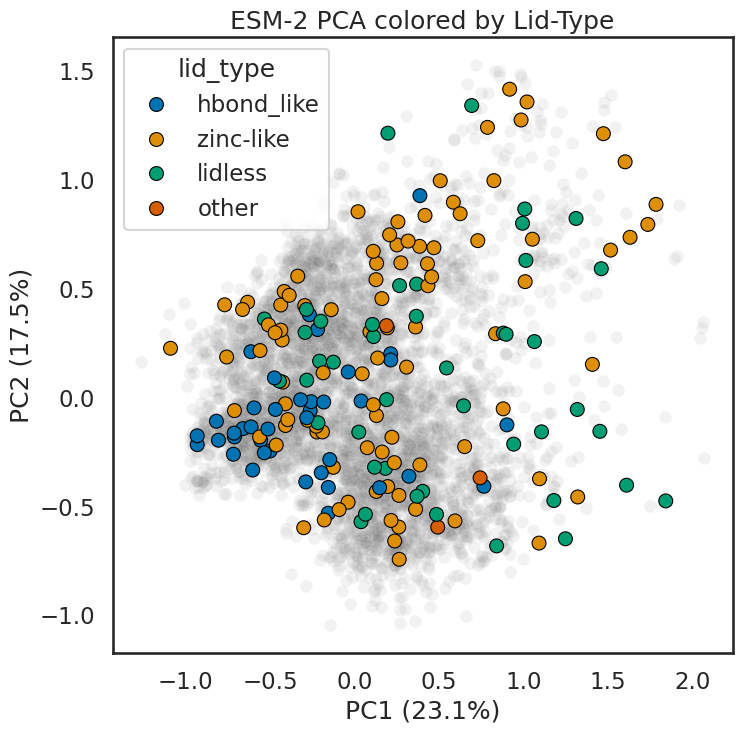

In [281]:
# same as above but grey out the non-first lib sequences
sns.set_context("talk")
sns.set_style("white")
sns.set_palette("colorblind")
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=esm_joined_pca_df, x="PC1", y="PC2", color="grey", ax=ax, alpha=0.1)
sns.scatterplot(data=esm_joined_pca_df[esm_joined_pca_df["org_in_first_lib"]], x="PC1", y="PC2", hue="lid_type", ax=ax, s=100, edgecolor="black")
# label axes with percent explained variance
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("ESM-2 PCA colored by Lid-Type")

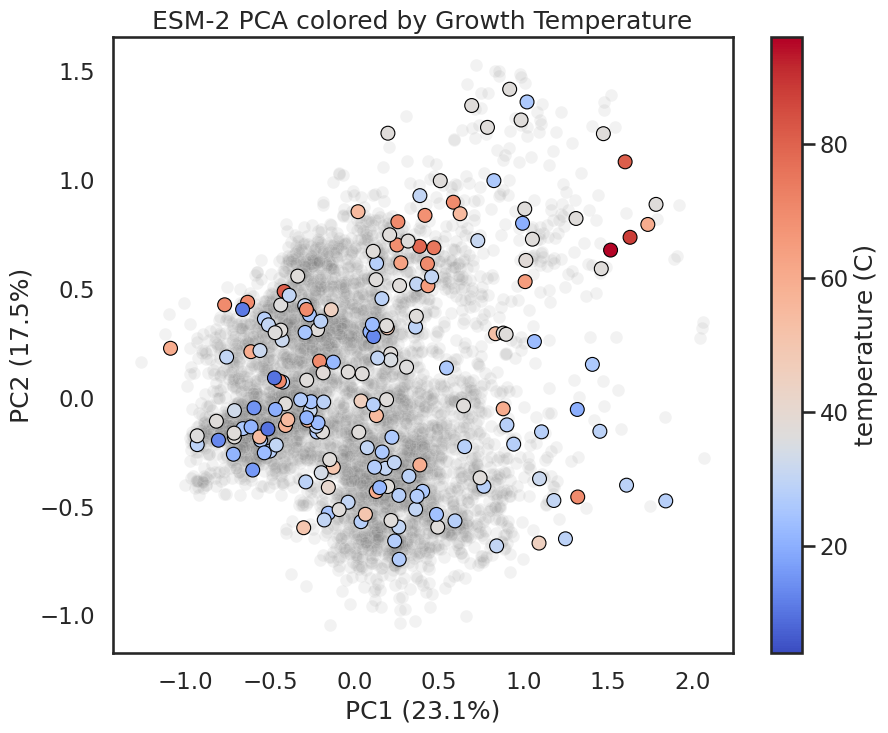

In [280]:
# same as above but grey out the non-first lib sequences
sns.set_context("talk")
sns.set_style("white")
sns.set_palette("colorblind")
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=esm_joined_pca_df, x="PC1", y="PC2", color="grey", ax=ax, alpha=0.1)
sns.scatterplot(data=esm_joined_pca_df[esm_joined_pca_df["org_in_first_lib"]], x="PC1", y="PC2",
color=esm_joined_pca_df[esm_joined_pca_df["org_in_first_lib"]]["temp_colors"],
 ax=ax, s=100, edgecolor="black",
legend=False)
# label axes with percent explained variance
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("ESM-2 PCA colored by Growth Temperature")
# add colorbar
sm = plt.cm.ScalarMappable(cmap=temp_cmap, norm=temp_normalize)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="temperature (C)")


In [270]:
esm_joined_pca_df["log10_kcat"] = np.log10(esm_joined_pca_df["kcat_mean_normed"])


/tmp/ipykernel_9482/2983339447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esm_joined_pca_df["log10_kcat"] = np.log10(esm_joined_pca_df["kcat_mean_normed"])


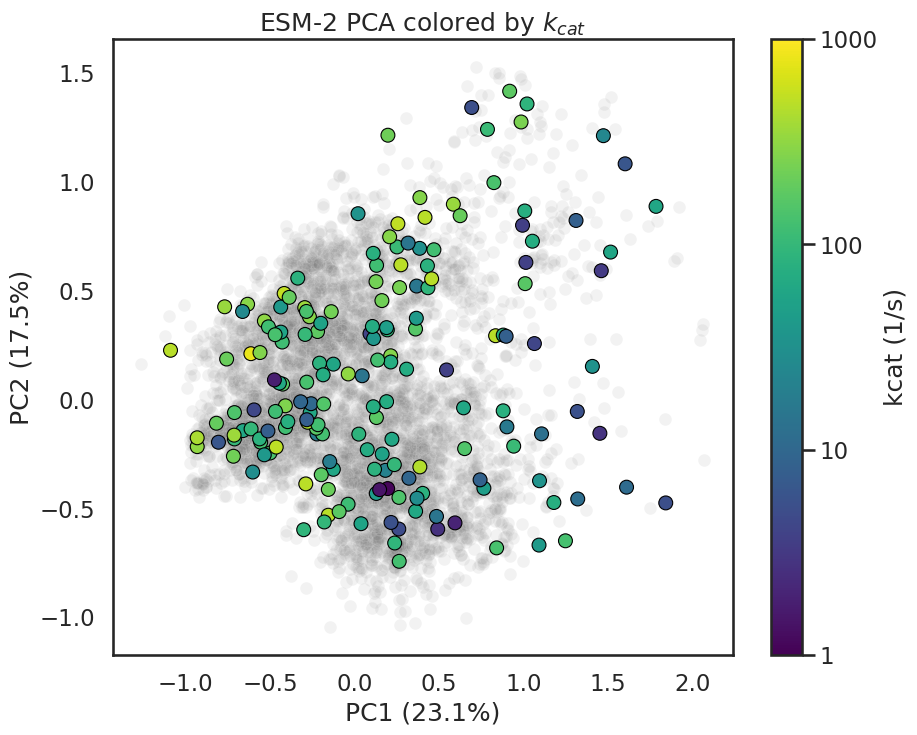

In [279]:
# same as above but grey out the non-first lib sequences and color by kcat, and use plasma colormap
sns.set_context("talk")
sns.set_style("white")
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=esm_joined_pca_df, x="PC1", y="PC2", color="grey", ax=ax, alpha=0.1)
sns.scatterplot(data=esm_joined_pca_df[~esm_joined_pca_df["log10_kcat"].isna()], x="PC1", y="PC2",
 ax=ax, s=100, edgecolor="black",
color=kcat_colors,
legend=False)
# label axes with percent explained variance
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("ESM-2 PCA colored by $k_{cat}$")
# add colorbar
#sm = plt.cm.ScalarMappable(cmap=kcat_cmap, norm=kcat_normalize)
#sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label="kcat (1/s)")
cbar.set_ticks([0,1, 2, 3])
ticks = cbar.get_ticks()
ticks = 10**ticks
cbar.set_ticklabels(ticks)
    

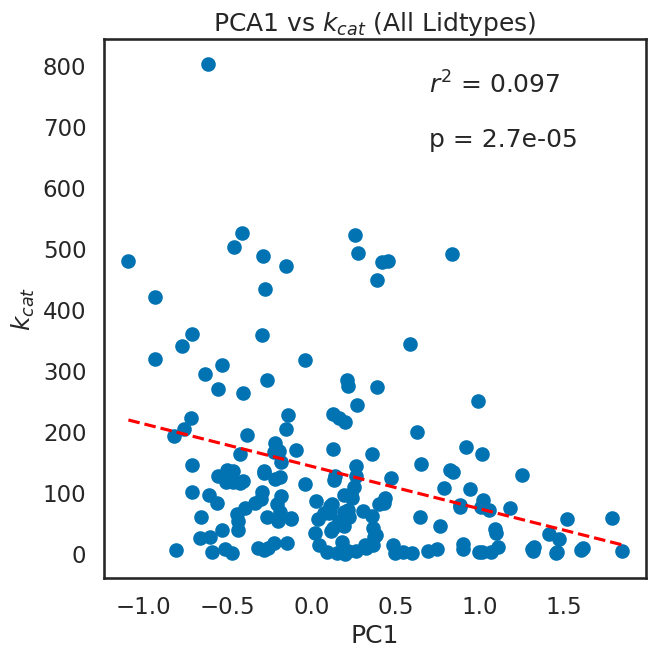

In [30]:
fig, ax = plt.subplots(figsize=(7,7))
x = esm_joined_pca_df[~esm_joined_pca_df["kcat_mean_normed"].isna()]["PC1"]
y = esm_joined_pca_df[~esm_joined_pca_df["kcat_mean_normed"].isna()]["kcat_mean_normed"]
ax.scatter(x, y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

x_lin = np.linspace(min(x), max(x), 100)
ax.plot(x_lin, slope*x_lin + intercept, color="red", linestyle="--")
ax.set_xlabel("PC1")
ax.set_ylabel("$k_{cat}$")
ax.text(0.6, 0.9, f"$r^2$ = {r_value**2:.2}", transform=ax.transAxes)
ax.text(0.6, 0.8, f"p = {p_value:.2}", transform=ax.transAxes)
ax.set_title("PCA1 vs $k_{cat}$ (All Lidtypes)")
plt.show()

In [19]:
pca_subset = esm_joined_pca_df[~esm_joined_pca_df["kcat_mean_normed"].isna()]
pca_subset["is_lidless"] = pca_subset["lid_type"] == "lidless"

/tmp/ipykernel_2678770/4195388077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_subset["is_lidless"] = pca_subset["lid_type"] == "lidless"


0.02573729604086096 -0.1941060145158176


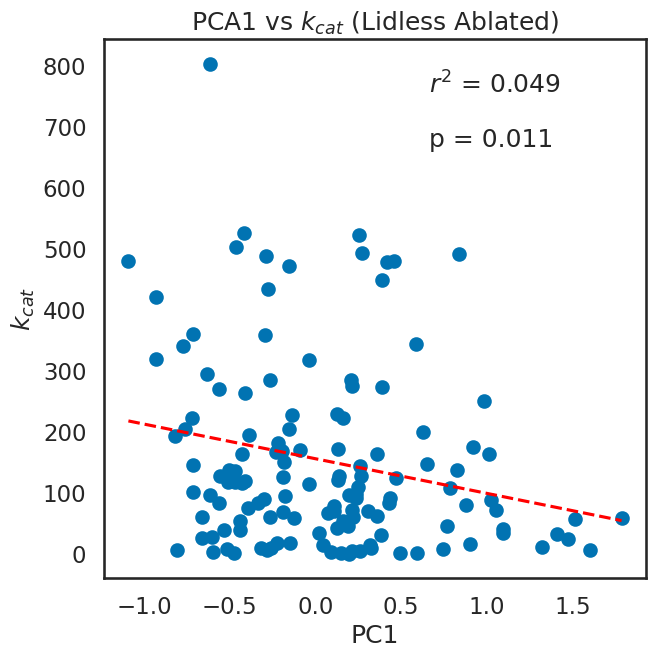

In [29]:
fig, ax = plt.subplots(figsize=(7,7))
x = esm_joined_pca_df[~esm_joined_pca_df["kcat_mean_normed"].isna() & (esm_joined_pca_df["lid_type"] != "lidless")]["PC1"]
y = esm_joined_pca_df[~esm_joined_pca_df["kcat_mean_normed"].isna() & (esm_joined_pca_df["lid_type"] != "lidless")]["kcat_mean_normed"]
ax.scatter(x, y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
x_lin = np.linspace(min(x), max(x), 100)
spearman_rho, spearman_p_value = stats.spearmanr(x, y)
print(spearman_p_value, spearman_rho)
ax.plot(x_lin, slope*x_lin + intercept, color="red", linestyle="--")
ax.set_xlabel("PC1")
ax.set_ylabel("$k_{cat}$")
ax.text(0.6, 0.9, f"$r^2$ = {r_value**2:.2}", transform=ax.transAxes)
ax.text(0.6, 0.8, f"p = {p_value:.2}", transform=ax.transAxes)
ax.set_title("PCA1 vs $k_{cat}$ (Lidless Ablated)")
plt.show()

1.9060955681917514e-05 -0.36283282807991524


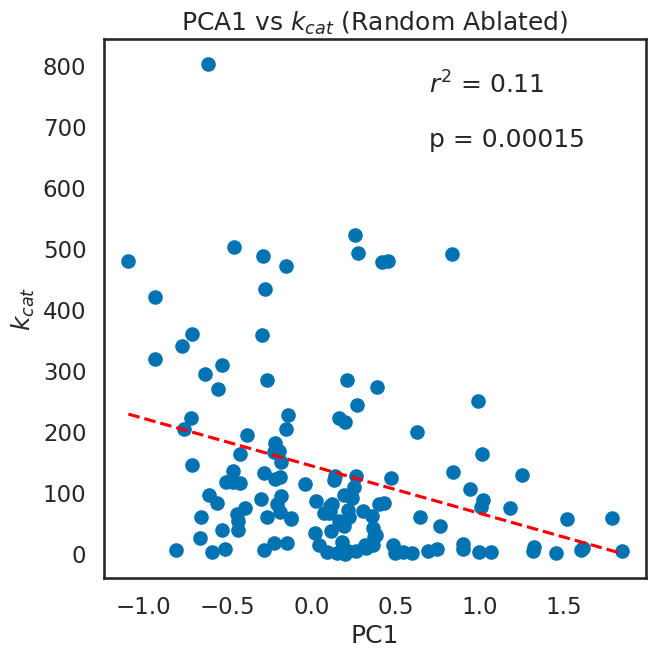

In [32]:
# random subset ablated of equal size to lidless
fig, ax = plt.subplots(figsize=(7,7))
# random subset of equal size to lidless
lidless_subset = esm_joined_pca_df[~esm_joined_pca_df["kcat_mean_normed"].isna() & (esm_joined_pca_df["lid_type"] == "lidless")]
ablated_subset = esm_joined_pca_df[~esm_joined_pca_df["kcat_mean_normed"].isna()].sample(n=len(esm_joined_pca_df[~esm_joined_pca_df["kcat_mean_normed"].isna()]) - len(lidless_subset))

x = ablated_subset["PC1"]
y = ablated_subset["kcat_mean_normed"]
ax.scatter(x, y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
x_lin = np.linspace(min(x), max(x), 100)
spearman_rho, spearman_p_value = stats.spearmanr(x, y)
print(spearman_p_value, spearman_rho)
ax.plot(x_lin, slope*x_lin + intercept, color="red", linestyle="--")
ax.set_xlabel("PC1")
ax.set_ylabel("$k_{cat}$")
ax.text(0.6, 0.9, f"$r^2$ = {r_value**2:.2}", transform=ax.transAxes)
ax.text(0.6, 0.8, f"p = {p_value:.2}", transform=ax.transAxes)
ax.set_title("PCA1 vs $k_{cat}$ (Random Ablated)")
plt.show()

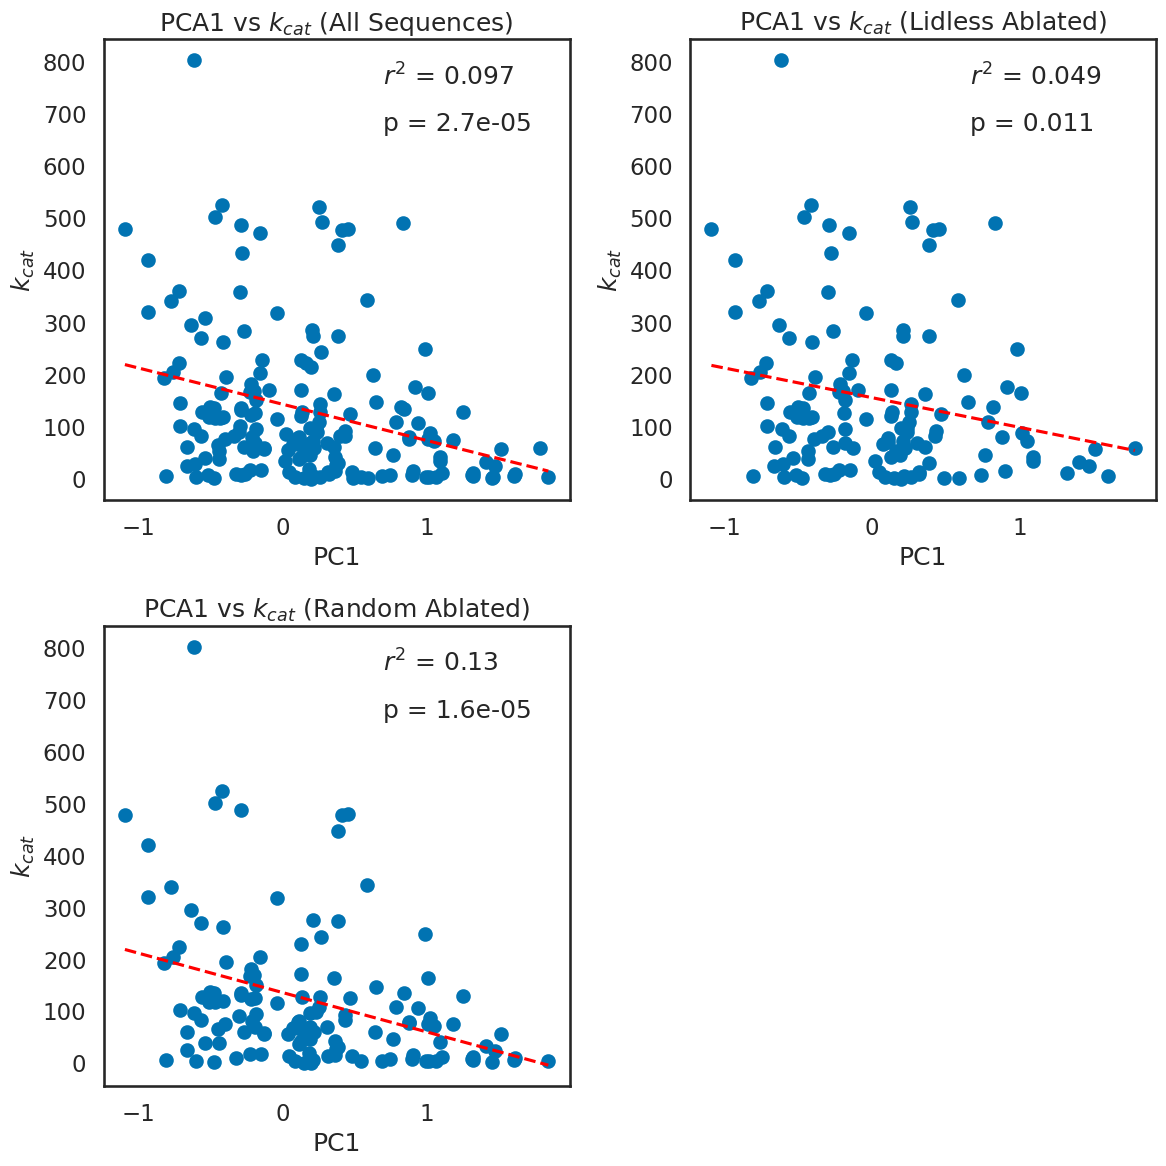

In [44]:
np.random.seed(314)
# PC1 linear regressions
fig, ax = plt.subplots(2,2,figsize=(12,12))
ax = ax.flatten()
# all sequences
x = esm_joined_pca_df[~esm_joined_pca_df["kcat_mean_normed"].isna()]["PC1"]
y = esm_joined_pca_df[~esm_joined_pca_df["kcat_mean_normed"].isna()]["kcat_mean_normed"]
ax[0].scatter(x, y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
x_lin = np.linspace(min(x), max(x), 100)

ax[0].plot(x_lin, slope*x_lin + intercept, color="red", linestyle="--")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("$k_{cat}$")
ax[0].text(0.6, 0.9, f"$r^2$ = {r_value**2:.2}", transform=ax[0].transAxes)
ax[0].text(0.6, 0.8, f"p = {p_value:.2}", transform=ax[0].transAxes)
ax[0].set_title("PCA1 vs $k_{cat}$ (All Sequences)")

# lidless
x = esm_joined_pca_df[~esm_joined_pca_df["kcat_mean_normed"].isna() & (esm_joined_pca_df["lid_type"] != "lidless")]["PC1"]
y = esm_joined_pca_df[~esm_joined_pca_df["kcat_mean_normed"].isna() & (esm_joined_pca_df["lid_type"] != "lidless")]["kcat_mean_normed"]
ax[1].scatter(x, y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
x_lin = np.linspace(min(x), max(x), 100)

ax[1].plot(x_lin, slope*x_lin + intercept, color="red", linestyle="--")
ax[1].set_xlabel("PC1")
ax[1].set_ylabel("$k_{cat}$")
ax[1].text(0.6, 0.9, f"$r^2$ = {r_value**2:.2}", transform=ax[1].transAxes)
ax[1].text(0.6, 0.8, f"p = {p_value:.2}", transform=ax[1].transAxes)
ax[1].set_title("PCA1 vs $k_{cat}$ (Lidless Ablated)")

# random subset ablated of equal size to lidless
# random subset ablated of equal size to lidless
# random subset of equal size to lidless
lidless_subset = esm_joined_pca_df[~esm_joined_pca_df["kcat_mean_normed"].isna() & (esm_joined_pca_df["lid_type"] == "lidless")]
ablated_subset = esm_joined_pca_df[~esm_joined_pca_df["kcat_mean_normed"].isna()].sample(n=len(esm_joined_pca_df[~esm_joined_pca_df["kcat_mean_normed"].isna()]) - len(lidless_subset))

x = ablated_subset["PC1"]
y = ablated_subset["kcat_mean_normed"]
ax[2].scatter(x, y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
x_lin = np.linspace(min(x), max(x), 100)

ax[2].plot(x_lin, slope*x_lin + intercept, color="red", linestyle="--")
ax[2].set_xlabel("PC1")
ax[2].set_ylabel("$k_{cat}$")
ax[2].text(0.6, 0.9, f"$r^2$ = {r_value**2:.2}", transform=ax[2].transAxes)
ax[2].text(0.6, 0.8, f"p = {p_value:.2}", transform=ax[2].transAxes)
ax[2].set_title("PCA1 vs $k_{cat}$ (Random Ablated)")

# delete the last subplot
fig.delaxes(ax[3])

plt.tight_layout()
plt.show()


# Trustworthiness

In [96]:
esm_kcat_df = pd.merge(esm_df, full_msa_df[["org_name", "kcat_mean_normed", "Km_mean_filtered", "temperature", "lid_type"]], left_on="Organism", right_on="org_name").dropna()
# drop "org_name" column
esm_kcat_df = esm_kcat_df.drop(columns="org_name")

In [97]:
esm_kcat_df["kcat/km"] = esm_kcat_df["kcat_mean_normed"] / (esm_kcat_df["Km_mean_filtered"] * 1e-6)
esm_kcat_df

,Organism,0,1,2,3,4,5,6,7,8,...,1275,1276,1277,1278,1279,kcat_mean_normed,Km_mean_filtered,temperature,lid_type,kcat/km
42,halorhodospira_halophila,-0.023725,-0.092798,-0.029872,-0.022359,-0.068173,-0.013176,0.090820,-0.159135,-0.036496,...,-0.053178,0.031445,-0.217937,0.033188,0.134948,472.019613,1600.584260,25,hbond_like,294904.570285
65,thermodesulfobacterium_commune,0.060950,-0.180645,-0.065778,-0.025962,-0.062372,-0.004487,0.144238,-0.176745,-0.019759,...,-0.091061,0.150094,-0.218771,-0.005858,0.030811,294.574930,1781.817010,70,zinc-like,165322.773521
84,mycoplasma_mycoides,0.035417,-0.095213,0.018344,0.027295,-0.034994,-0.077368,0.085725,-0.075198,-0.011360,...,-0.027175,0.168039,-0.117382,-0.050355,0.014890,108.740136,488.685217,37,zinc-like,222515.705647
89,methanococcoides_burtonii,-0.006738,-0.119823,-0.016078,0.024873,-0.085920,0.006583,0.115276,-0.157556,-0.048481,...,-0.021547,0.078722,-0.158723,0.003392,0.073220,3.974143,250.492426,21,zinc-like,15865.321728
97,kushneria_avicenniae,-0.008356,-0.075535,-0.013548,-0.047173,-0.059048,-0.044874,0.064435,-0.107373,-0.046200,...,-0.023046,0.054774,-0.214112,0.050900,0.096257,9.443869,1172.234090,29,hbond_like,8056.299550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5058,leptospira_interrogans,-0.011847,-0.133139,-0.034747,-0.001639,-0.096570,-0.046451,0.130321,-0.162977,-0.010220,...,-0.075315,0.066726,-0.204966,-0.047183,0.085945,53.879890,244.049750,29,lidless,220774.204891
5085,clostridium_botulinum,0.015218,-0.129387,0.009222,0.027519,-0.075566,-0.039032,0.100546,-0.129371,-0.045614,...,-0.031810,0.087574,-0.186153,0.006016,0.044501,229.194403,680.844578,37,zinc-like,336632.486923
5113,fervidobacterium_nodosum,0.047580,-0.161531,-0.016575,-0.008355,-0.041492,-0.015434,0.117099,-0.161778,-0.002245,...,-0.055200,0.155194,-0.160440,-0.030242,-0.003683,522.512976,1600.099140,70,zinc-like,326550.376122
5128,desulfatibacillum_alkenivorans,-0.049950,-0.055665,-0.021390,0.025127,-0.060142,-0.014679,0.090936,-0.163097,-0.010586,...,-0.031424,0.051844,-0.200930,0.015923,0.051656,479.599470,1702.335550,30,zinc-like,281730.279321


In [98]:
one_hot_df = pd.read_csv(one_hot_embedding_path)

In [99]:
one_hot_kcat_df = pd.merge(one_hot_df, full_msa_df[["org_name", "kcat_mean_normed", "Km_mean_filtered", "lid_type"]], on="org_name").dropna()

In [100]:
one_hot_kcat_df["kcat/km"] = one_hot_kcat_df["kcat_mean_normed"] / (one_hot_kcat_df["Km_mean_filtered"] * 1e-6)
one_hot_kcat_df

,0,1,2,3,4,5,6,7,8,9,...,7261,7262,7263,7264,7265,org_name,kcat_mean_normed,Km_mean_filtered,lid_type,kcat/km
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,azorhizobium_caulinodans,20.287820,228.294494,lidless,88866.882703
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,methylocella_silvestris,123.061061,1066.598980,lidless,115377.065896
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,bartonella_henselae,77.856752,342.284019,lidless,227462.421171
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,sorangium_cellulosum,12.518474,216.297684,lidless,57876.134078
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,elusimicrobium_minutum,138.364545,1725.243090,zinc-like,80200.028739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,treponema_putidum,285.696479,1573.778450,zinc-like,181535.386064
171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,veillonella_seminalis,132.249815,343.705960,lidless,384776.030069
172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,verminephrobacter_aporrectodeae,1.436920,932.121022,hbond_like,1541.559318
173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,virgibacillus_dokdonensis,194.988192,379.137519,zinc-like,514294.106567


## Trustworthiness Dev
___

In [101]:
kcats = one_hot_kcat_df["kcat_mean_normed"]

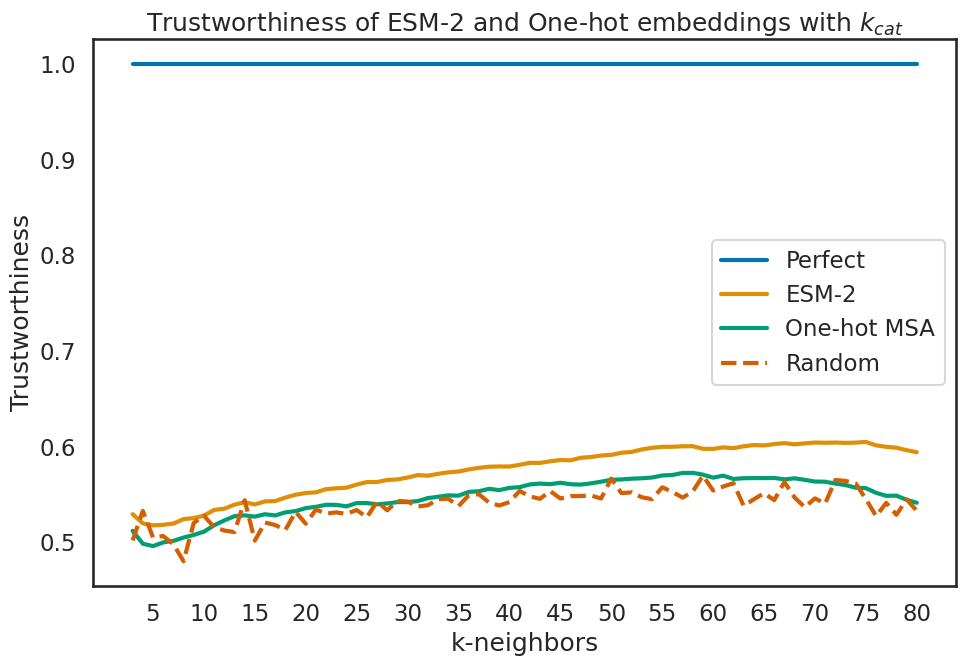

In [56]:
TOP_N = 80
np.random.seed(314)
kcat_trust = []

kcat_shuffled_trust = []
esm_kcat_trust = []
esm_temp_trust = []
one_hot_kcat_trust = []
for k in range(3, TOP_N+1):
    esm_kcat_trust.append(trustworthiness(esm_kcat_df.iloc[:, 1:-5], esm_kcat_df["kcat_mean_normed"].to_numpy().reshape(-1,1), n_neighbors=k))
    kcat_trust.append(trustworthiness(esm_kcat_df["kcat_mean_normed"].to_numpy().reshape(-1,1), esm_kcat_df["kcat_mean_normed"].to_numpy().reshape(-1,1), n_neighbors=k))
    kcat_shuffled_trust.append(trustworthiness(esm_kcat_df["kcat_mean_normed"].to_numpy().reshape(-1,1), np.random.permutation(esm_kcat_df["kcat_mean_normed"].to_numpy()).reshape(-1,1), n_neighbors=k))
    one_hot_kcat_trust.append(trustworthiness(one_hot_kcat_df.iloc[:, :-5], one_hot_kcat_df["kcat_mean_normed"].to_numpy().reshape(-1,1), n_neighbors=k, metric="hamming"))

# Get the Viridis colormap
viridis_cmap = cm.get_cmap('viridis')

# Pick 4 colors from the Viridis colormap
colors_list = [viridis_cmap(i) for i in [0, 0.4, 0.6, 0.8]]

# Create a ListedColormap with the selected colors
custom_cmap = colors.ListedColormap(colors_list)

# plot trustworthiness
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(range(3, TOP_N + 1), kcat_trust, label="Perfect", linewidth=3)


ax.plot(range(3, TOP_N + 1), esm_kcat_trust, label="ESM-2", linewidth=3)
ax.plot(range(3, TOP_N + 1), one_hot_kcat_trust, label="One-hot MSA", linewidth=3)
ax.plot(range(3, TOP_N + 1), kcat_shuffled_trust, label="Random", linewidth=3, linestyle="--")


ax.set_xlabel("k-neighbors")
ax.set_ylabel("Trustworthiness")
ax.set_title("Trustworthiness of ESM-2 and One-hot embeddings with $k_{cat}$")
# set xtickst so 5, 10, 15, 20 are labeled
ax.set_xticks(range(5, TOP_N+1, 5))

ax.legend()
plt.tight_layout()

plt.rcParams['pdf.fonttype'] = 42
#plt.savefig("../data/fig_pdfs/trustworthiness.pdf")

## Lid-type Trustworthiness ESM

In [103]:
def compute_trustworthiness_by_lidtype(df, lid_types, col_name, embedding_start_idx, embedding_end_idx, top_n_neighbors, metric="euclidean", random_shuffle_n=30):
    np.random.seed(314)

    trust_result_dict = {
        "perfect": [],
        "shuffled": [],
        "all": [],

    }
    for lidtype in lid_types:
        trust_result_dict[lidtype] = []
        trust_result_dict[lidtype + "_shuffled"] = []

    subset_dfs = []
    for lidtype in lid_types:
        subset_dfs.append(df[df["lid_type"] == lidtype])

    for k in range(3, top_n_neighbors+1):
        trust_result_dict["perfect"].append(trustworthiness(df[col_name].to_numpy().reshape(-1,1), df[col_name].to_numpy().reshape(-1,1), n_neighbors=k))
        trust_result_dict["all"].append(trustworthiness(df.iloc[:, embedding_start_idx:embedding_end_idx], df[col_name].to_numpy().reshape(-1,1), n_neighbors=k, metric=metric))
    
        for i, lidtype in enumerate(lid_types):
            lidtype_df = subset_dfs[i]
            trust_result_dict[lidtype].append(trustworthiness(lidtype_df.iloc[:, embedding_start_idx:embedding_end_idx], lidtype_df[col_name].to_numpy().reshape(-1,1), n_neighbors=k, metric=metric))
            lidtype_random = []
            for i in range(random_shuffle_n):
                lidtype_random.append(trustworthiness(lidtype_df.iloc[:, embedding_start_idx:embedding_end_idx], np.random.permutation(lidtype_df[col_name].to_numpy()).reshape(-1,1), n_neighbors=k, metric=metric))
            trust_result_dict[lidtype + "_shuffled"].append(np.mean(lidtype_random))
            
      
        all_random = []
        for i in range(random_shuffle_n):
            all_random.append(trustworthiness(df.iloc[:, embedding_start_idx:embedding_end_idx], np.random.permutation(df[col_name].to_numpy()).reshape(-1,1), n_neighbors=k, metric=metric))

       
        trust_result_dict["shuffled"].append(np.mean(all_random))
    return trust_result_dict

  

kcat_esm_trust_dict = compute_trustworthiness_by_lidtype(df=esm_kcat_df, 
                                   lid_types=["hbond_like", "zinc-like", "lidless"], 
                                   col_name="kcat_mean_normed", 
                                   embedding_start_idx=1,
                                   embedding_end_idx=-5,
                                   top_n_neighbors=15)

In [ ]:
lid_colors = {'all': 'orange', 'zinc-like': 'blue', 'lidless': 'green', 'hbond_like': 'red'}

def plot_lidtype_trust_linechart(trust_dict, lid_types, top_n_neighbors, lid_colors, title, min_neighbor=3):
    fig, ax = plt.subplots(figsize=(10, 8))
    for lidtype in lid_types:
        ax.plot(range(min_neighbor, top_n_neighbors + 1), trust_dict[lidtype], label=lidtype, linewidth=3, color=lid_colors[lidtype])
        ax.plot(range(min_neighbor, top_n_neighbors + 1), trust_dict[lidtype + "_shuffled"], label=lidtype + " Random", linewidth=3, linestyle='dashed', color=lid_colors[lidtype])
    ax.plot(range(min_neighbor, top_n_neighbors + 1), trust_dict["perfect"], label="Perfect", linewidth=3, color=lid_colors["all"])
    ax.set_xlabel("k-neighbors")
    ax.set_ylabel("Trustworthiness")
    ax.set_title(title)
    ax.set_xticks(range(5, top_n_neighbors+1, 5))
    ax.legend()
    plt.tight_layout()



In [ ]:
km_esm_trust_dict = compute_trustworthiness_by_lidtype(df=esm_kcat_df,
                                      lid_types=["hbond_like", "zinc-like", "lidless"], 
                                      col_name="Km_mean_filtered", 
                                      embedding_start_idx=1,
                                      embedding_end_idx=-5,
                                      top_n_neighbors=15)

In [ ]:
kcat_km_esm_trust_dict = compute_trustworthiness_by_lidtype(df=esm_kcat_df,
                                        lid_types=["hbond_like", "zinc-like", "lidless"], 
                                        col_name="kcat/km", 
                                        embedding_start_idx=1,
                                        embedding_end_idx=-5,
                                        top_n_neighbors=15)

## Lid-type Trustworthiness One-hot

In [ ]:
kcat_one_hot_trust_dict = compute_trustworthiness_by_lidtype(df=one_hot_kcat_df,
                                      lid_types=["hbond_like", "zinc-like", "lidless"], 
                                      col_name="kcat_mean_normed", 
                                      embedding_start_idx=0,
                                      embedding_end_idx=-5,
                                      top_n_neighbors=15,
                                      metric="hamming",
                                      random_shuffle_n=30)


In [ ]:
km_one_hot_trust_dict = compute_trustworthiness_by_lidtype(df=one_hot_kcat_df,
                                        lid_types=["hbond_like", "zinc-like", "lidless"], 
                                        col_name="Km_mean_filtered", 
                                        embedding_start_idx=0,
                                        embedding_end_idx=-5,
                                        top_n_neighbors=15,
                                        metric="hamming",
                                        random_shuffle_n=30)

In [ ]:
kcat_km_one_hot_trust_dict = compute_trustworthiness_by_lidtype(df=one_hot_kcat_df,
                                        lid_types=["hbond_like", "zinc-like", "lidless"], 
                                        col_name="kcat/km", 
                                        embedding_start_idx=0,
                                        embedding_end_idx=-5,
                                        top_n_neighbors=15,
                                        metric="hamming",
                                        random_shuffle_n=30)

0 Rectangle(xy=(-0.4, 0), width=0.4, height=0.51779, angle=0)
1 Rectangle(xy=(0.6, 0), width=0.4, height=0.589635, angle=0)
2 Rectangle(xy=(1.6, 0), width=0.4, height=0.587018, angle=0)
3 Rectangle(xy=(2.6, 0), width=0.4, height=0.51373, angle=0)
4 Rectangle(xy=(5.55112e-17, 0), width=0.4, height=0.496109, angle=0)
5 Rectangle(xy=(1, 0), width=0.4, height=0.537143, angle=0)
6 Rectangle(xy=(2, 0), width=0.4, height=0.544386, angle=0)
7 Rectangle(xy=(3, 0), width=0.4, height=0.508407, angle=0)
8 Rectangle(xy=(0, 0), width=0, height=0, angle=0)
9 Rectangle(xy=(0, 0), width=0, height=0, angle=0)


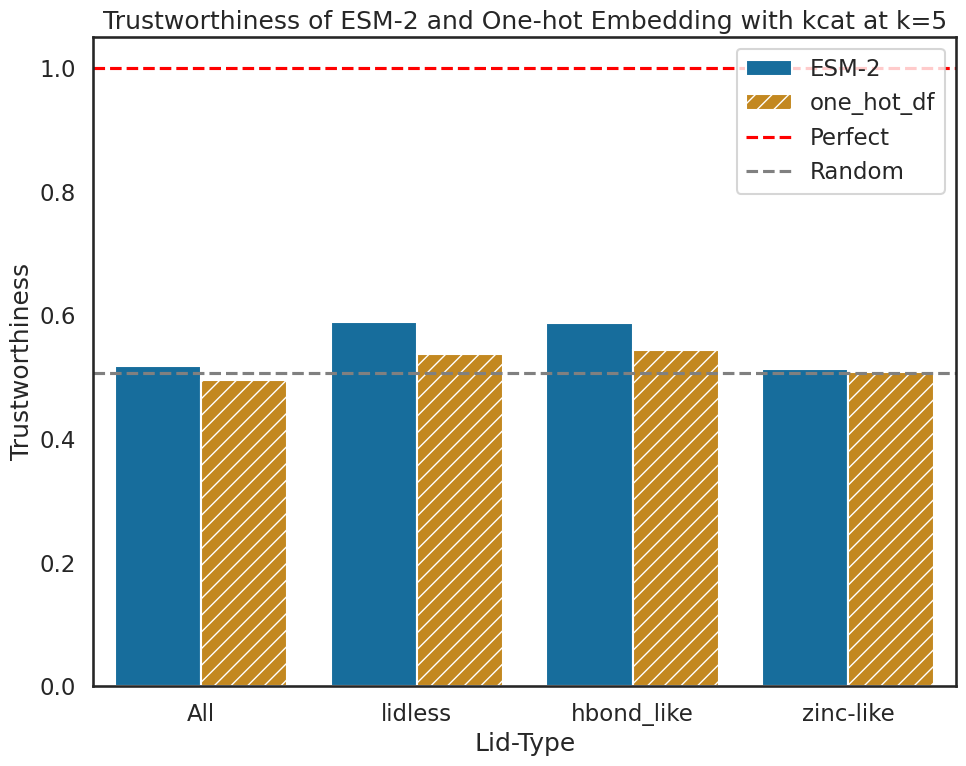

In [109]:
def plot_barplot_trust_by_lidtype(method_trust_dict, lid_types, k, title):
    fig, ax = plt.subplots(figsize=(10, 8))

    idx = k - 3
    df_dict = {"Lidtype": ["All"] + lid_types}
    for method, trust_dict in method_trust_dict.items():
        df_dict[method] = [trust_dict[lidtype][idx] for lidtype in ["all"] + lid_types]

    trustworthiness_df = pd.DataFrame(df_dict)

    trustworthiness_df = trustworthiness_df.melt(id_vars="Lidtype", var_name="Method", value_name="Trustworthiness")
    sns.barplot(data=trustworthiness_df, x="Lidtype", y="Trustworthiness", hue="Method", ax=ax, palette="colorblind")

    # set one-hot to be hatched
    for i, bar in enumerate(ax.patches):
        print(i, bar)
        if 8 > i > 3:
            bar.set_hatch("//")
        if i == 9:
            bar.set_hatch("//")

    ax.set_xlabel("Lid-Type")
    ax.set_ylabel("Trustworthiness")
    
    ax.axhline(y=method_trust_dict["ESM-2"]["perfect"][2], color='r', linestyle='--', label="Perfect")
    ax.axhline(y=method_trust_dict["ESM-2"]["shuffled"][2], color='grey', linestyle='--', label="Random")

    #ax.axhline(y=kcat_shuffled_trust[2], color='b', linestyle='--', label="Random")
    ax.set_title(title)
    ax.legend()
    plt.rcParams['pdf.fonttype'] = 42
    plt.tight_layout()
    plt.show()
    return
    #plt.savefig("../data/fig_pdfs/esm_onehot_lidtype_trustworthiness.pdf")
    

plot_barplot_trust_by_lidtype({ "ESM-2": kcat_esm_trust_dict,"one_hot_df": kcat_one_hot_trust_dict},["lidless","hbond_like", "zinc-like"], 5, "Trustworthiness of ESM-2 and One-hot Embedding with kcat at k=5")

0 Rectangle(xy=(-0.4, 0), width=0.4, height=0.516003, angle=0)
1 Rectangle(xy=(0.6, 0), width=0.4, height=0.533422, angle=0)
2 Rectangle(xy=(1.6, 0), width=0.4, height=0.520526, angle=0)
3 Rectangle(xy=(2.6, 0), width=0.4, height=0.511585, angle=0)
4 Rectangle(xy=(5.55112e-17, 0), width=0.4, height=0.524346, angle=0)
5 Rectangle(xy=(1, 0), width=0.4, height=0.546047, angle=0)
6 Rectangle(xy=(2, 0), width=0.4, height=0.501228, angle=0)
7 Rectangle(xy=(3, 0), width=0.4, height=0.504621, angle=0)
8 Rectangle(xy=(0, 0), width=0, height=0, angle=0)
9 Rectangle(xy=(0, 0), width=0, height=0, angle=0)


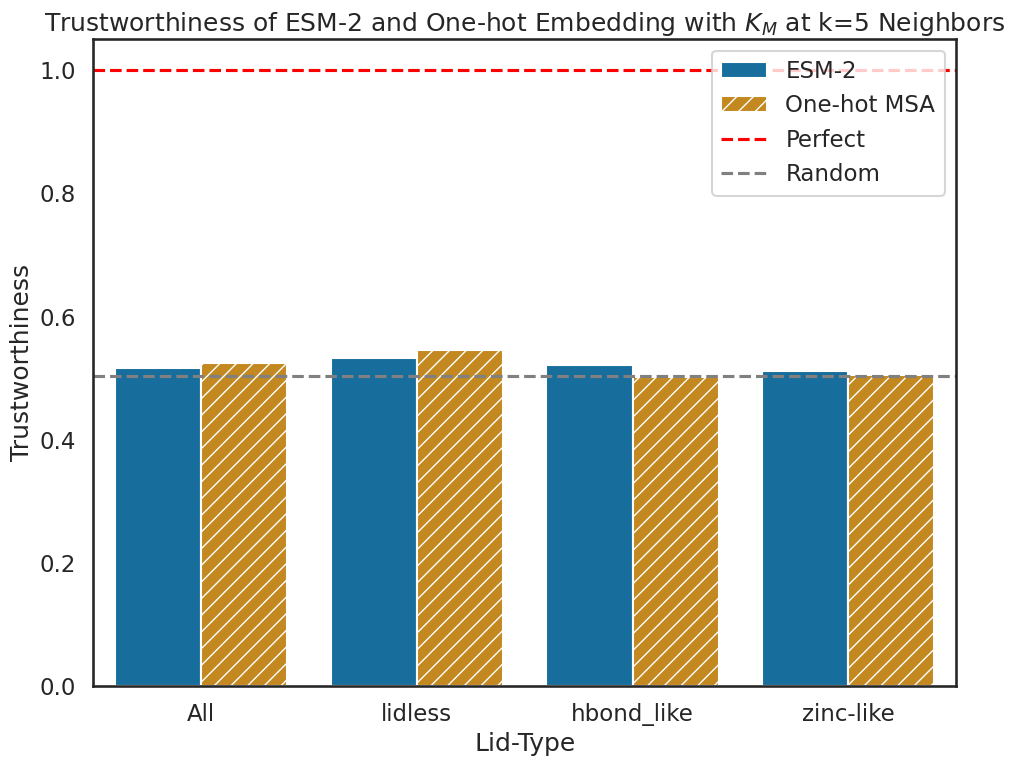

In [264]:
plot_barplot_trust_by_lidtype({ "ESM-2": km_esm_trust_dict,"One-hot MSA": km_one_hot_trust_dict},["lidless","hbond_like", "zinc-like"], 5, "Trustworthiness of ESM-2 and One-hot Embedding with $K_M$ at k=5 Neighbors")

0 Rectangle(xy=(-0.4, 0), width=0.4, height=0.540756, angle=0)
1 Rectangle(xy=(0.6, 0), width=0.4, height=0.573289, angle=0)
2 Rectangle(xy=(1.6, 0), width=0.4, height=0.542982, angle=0)
3 Rectangle(xy=(2.6, 0), width=0.4, height=0.551489, angle=0)
4 Rectangle(xy=(5.55112e-17, 0), width=0.4, height=0.52334, angle=0)
5 Rectangle(xy=(1, 0), width=0.4, height=0.548704, angle=0)
6 Rectangle(xy=(2, 0), width=0.4, height=0.53, angle=0)
7 Rectangle(xy=(3, 0), width=0.4, height=0.52824, angle=0)
8 Rectangle(xy=(0, 0), width=0, height=0, angle=0)
9 Rectangle(xy=(0, 0), width=0, height=0, angle=0)


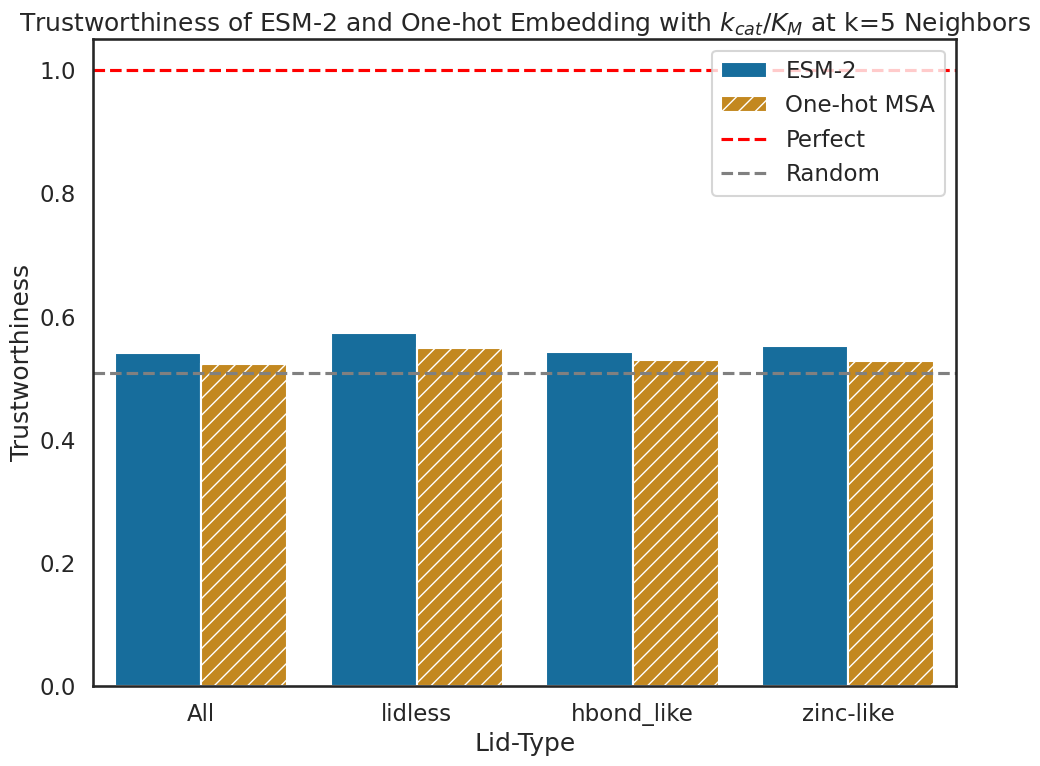

In [266]:
plot_barplot_trust_by_lidtype({ "ESM-2": kcat_km_esm_trust_dict,"One-hot MSA": kcat_km_one_hot_trust_dict},["lidless","hbond_like", "zinc-like"], 5, "Trustworthiness of ESM-2 and One-hot Embedding with $k_{cat}/K_M$ at k=5 Neighbors")

# Hierarchical Clustering
___

In [172]:
esm_kcat_df

,Organism,0,1,2,3,4,5,6,7,8,...,1274,1275,1276,1277,1278,1279,kcat_mean_normed,Km_mean_filtered,temperature,lid_type
42,halorhodospira_halophila,-0.023725,-0.092798,-0.029872,-0.022359,-0.068173,-0.013176,0.090820,-0.159135,-0.036496,...,-0.121991,-0.053178,0.031445,-0.217937,0.033188,0.134948,472.019613,1600.584260,25,hbond_like
65,thermodesulfobacterium_commune,0.060950,-0.180645,-0.065778,-0.025962,-0.062372,-0.004487,0.144238,-0.176745,-0.019759,...,-0.036454,-0.091061,0.150094,-0.218771,-0.005858,0.030811,294.574930,1781.817010,70,zinc-like
84,mycoplasma_mycoides,0.035417,-0.095213,0.018344,0.027295,-0.034994,-0.077368,0.085725,-0.075198,-0.011360,...,-0.067093,-0.027175,0.168039,-0.117382,-0.050355,0.014890,108.740136,488.685217,37,zinc-like
89,methanococcoides_burtonii,-0.006738,-0.119823,-0.016078,0.024873,-0.085920,0.006583,0.115276,-0.157556,-0.048481,...,-0.104757,-0.021547,0.078722,-0.158723,0.003392,0.073220,3.974143,250.492426,21,zinc-like
97,kushneria_avicenniae,-0.008356,-0.075535,-0.013548,-0.047173,-0.059048,-0.044874,0.064435,-0.107373,-0.046200,...,-0.103803,-0.023046,0.054774,-0.214112,0.050900,0.096257,9.443869,1172.234090,29,hbond_like
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5058,leptospira_interrogans,-0.011847,-0.133139,-0.034747,-0.001639,-0.096570,-0.046451,0.130321,-0.162977,-0.010220,...,-0.065745,-0.075315,0.066726,-0.204966,-0.047183,0.085945,53.879890,244.049750,29,lidless
5085,clostridium_botulinum,0.015218,-0.129387,0.009222,0.027519,-0.075566,-0.039032,0.100546,-0.129371,-0.045614,...,-0.098879,-0.031810,0.087574,-0.186153,0.006016,0.044501,229.194403,680.844578,37,zinc-like
5113,fervidobacterium_nodosum,0.047580,-0.161531,-0.016575,-0.008355,-0.041492,-0.015434,0.117099,-0.161778,-0.002245,...,-0.039256,-0.055200,0.155194,-0.160440,-0.030242,-0.003683,522.512976,1600.099140,70,zinc-like
5128,desulfatibacillum_alkenivorans,-0.049950,-0.055665,-0.021390,0.025127,-0.060142,-0.014679,0.090936,-0.163097,-0.010586,...,-0.114717,-0.031424,0.051844,-0.200930,0.015923,0.051656,479.599470,1702.335550,30,zinc-like


In [58]:
esm_first_lib_array = esm_kcat_df.iloc[:, 1:1281].to_numpy()

In [59]:
esm_first_lib_euclidean_array = euclidean_distances(esm_first_lib_array, esm_first_lib_array)

In [114]:
def generate_col_colors(labels, palette='husl'):
    """
    Generate an array of colors based on string labels for use in Seaborn's clustermap.
    
    Parameters
    ----------
    labels : list of str
        A list of string labels.
    palette : str, optional
        The name of a Seaborn palette to generate colors from.
        
    Returns
    -------
    col_colors : list of RGB tuples
        A list of colors corresponding to the labels.
    """
    unique_labels = np.unique(labels)
    n_unique_labels = len(unique_labels)
    
    # Generate a color palette
    colors = sns.color_palette(palette, n_unique_labels)
    
    # Map labels to colors
    label_to_color = dict(zip(unique_labels, colors))
    col_colors = [label_to_color[label] for label in labels]
    
    return col_colors, label_to_color

In [115]:
esm_row_linkage = hierarchy.linkage(
    distance.pdist(esm_first_lib_euclidean_array), method='average')

esm_col_linkage = hierarchy.linkage(
    distance.pdist(esm_first_lib_euclidean_array.T), method='average')

In [116]:
esm_kcat_lid_type = esm_kcat_df

In [117]:
esm_kcat_lid_type

,Organism,0,1,2,3,4,5,6,7,8,...,1275,1276,1277,1278,1279,kcat_mean_normed,Km_mean_filtered,temperature,lid_type,kcat/km
42,halorhodospira_halophila,-0.023725,-0.092798,-0.029872,-0.022359,-0.068173,-0.013176,0.090820,-0.159135,-0.036496,...,-0.053178,0.031445,-0.217937,0.033188,0.134948,472.019613,1600.584260,25,hbond_like,294904.570285
65,thermodesulfobacterium_commune,0.060950,-0.180645,-0.065778,-0.025962,-0.062372,-0.004487,0.144238,-0.176745,-0.019759,...,-0.091061,0.150094,-0.218771,-0.005858,0.030811,294.574930,1781.817010,70,zinc-like,165322.773521
84,mycoplasma_mycoides,0.035417,-0.095213,0.018344,0.027295,-0.034994,-0.077368,0.085725,-0.075198,-0.011360,...,-0.027175,0.168039,-0.117382,-0.050355,0.014890,108.740136,488.685217,37,zinc-like,222515.705647
89,methanococcoides_burtonii,-0.006738,-0.119823,-0.016078,0.024873,-0.085920,0.006583,0.115276,-0.157556,-0.048481,...,-0.021547,0.078722,-0.158723,0.003392,0.073220,3.974143,250.492426,21,zinc-like,15865.321728
97,kushneria_avicenniae,-0.008356,-0.075535,-0.013548,-0.047173,-0.059048,-0.044874,0.064435,-0.107373,-0.046200,...,-0.023046,0.054774,-0.214112,0.050900,0.096257,9.443869,1172.234090,29,hbond_like,8056.299550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5058,leptospira_interrogans,-0.011847,-0.133139,-0.034747,-0.001639,-0.096570,-0.046451,0.130321,-0.162977,-0.010220,...,-0.075315,0.066726,-0.204966,-0.047183,0.085945,53.879890,244.049750,29,lidless,220774.204891
5085,clostridium_botulinum,0.015218,-0.129387,0.009222,0.027519,-0.075566,-0.039032,0.100546,-0.129371,-0.045614,...,-0.031810,0.087574,-0.186153,0.006016,0.044501,229.194403,680.844578,37,zinc-like,336632.486923
5113,fervidobacterium_nodosum,0.047580,-0.161531,-0.016575,-0.008355,-0.041492,-0.015434,0.117099,-0.161778,-0.002245,...,-0.055200,0.155194,-0.160440,-0.030242,-0.003683,522.512976,1600.099140,70,zinc-like,326550.376122
5128,desulfatibacillum_alkenivorans,-0.049950,-0.055665,-0.021390,0.025127,-0.060142,-0.014679,0.090936,-0.163097,-0.010586,...,-0.031424,0.051844,-0.200930,0.015923,0.051656,479.599470,1702.335550,30,zinc-like,281730.279321


In [118]:
esm_col_colors, esm_col_color_dict = generate_col_colors(list(esm_kcat_lid_type['lid_type']))
esm_handles = [Patch(facecolor=esm_col_color_dict[name]) for name in esm_col_color_dict]


In [148]:
# colormap kcat with viridis
kcat_cmap = matplotlib.colormaps["viridis"]
kcat_normalize = plt.Normalize(vmin=0, 
                               vmax=3)
esm_kcat_colors = [kcat_cmap(kcat_normalize(np.log10(value))) for value in esm_kcat_lid_type["kcat_mean_normed"]]

Text(0.5, 1.0, 'ESM-2: Euclidean Distance Clustermap')

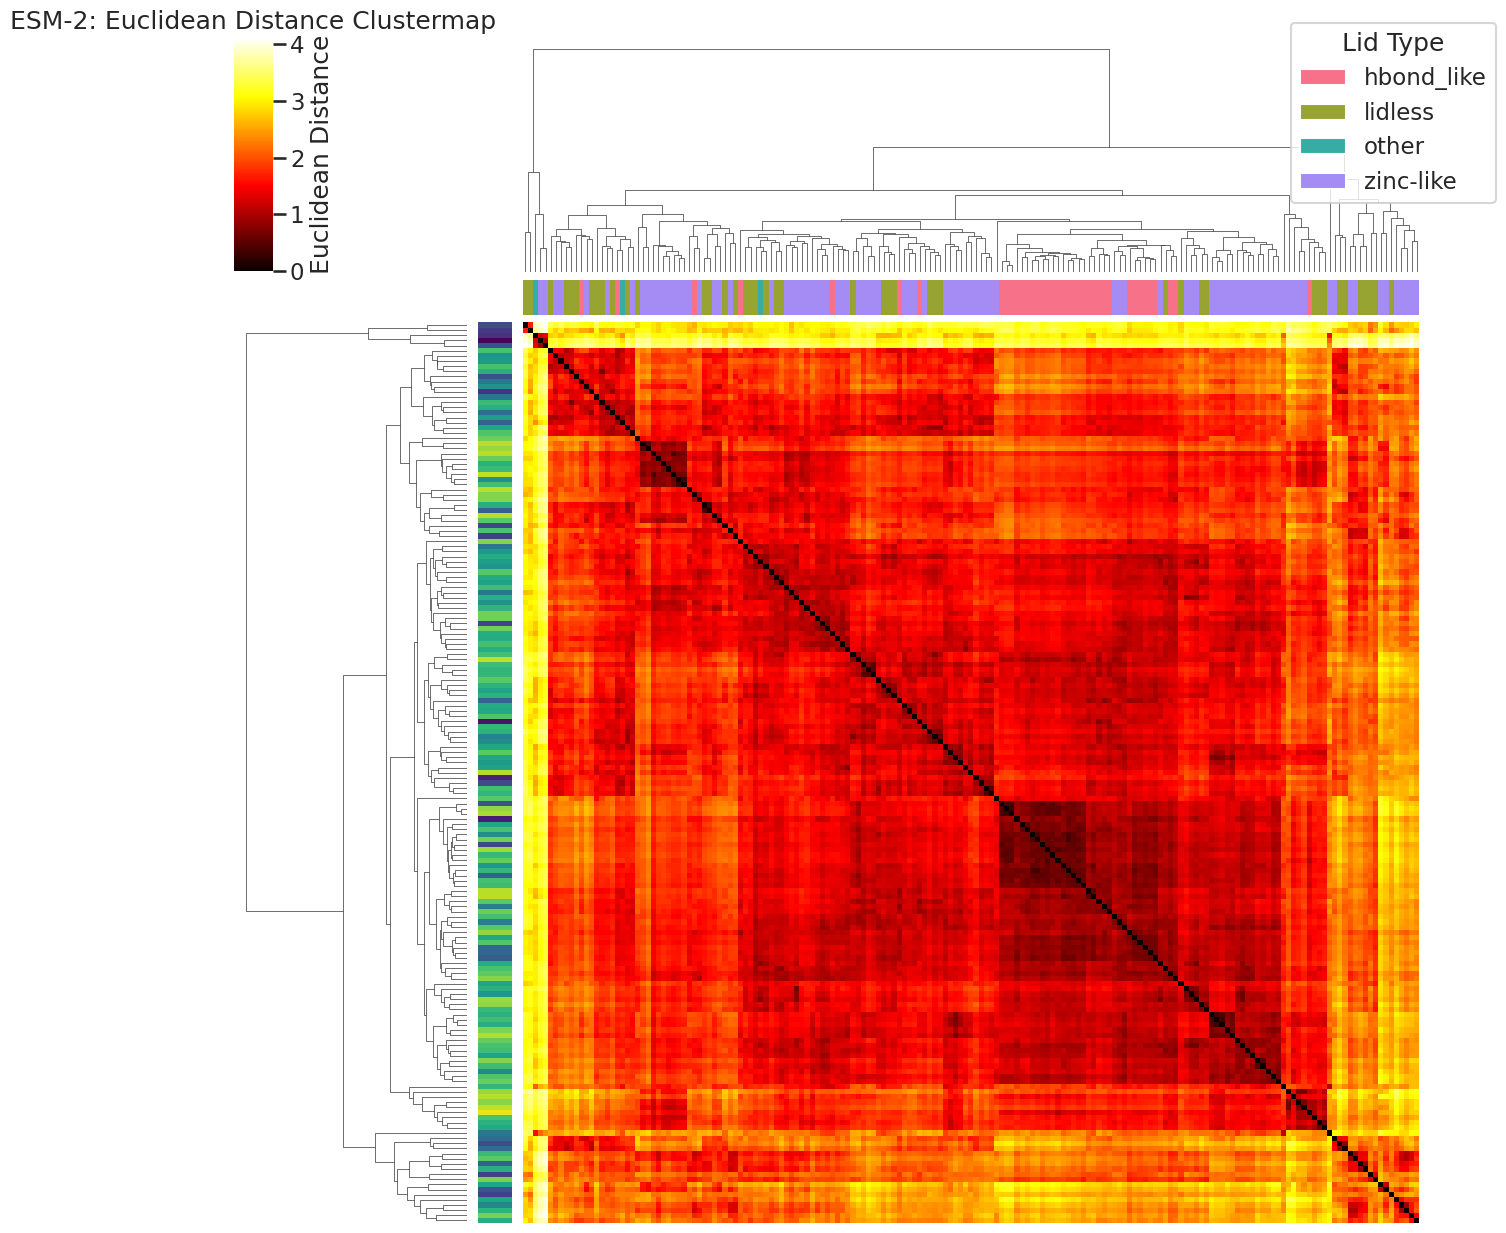

In [167]:
cg = sns.clustermap(
    esm_first_lib_euclidean_array,
    row_linkage=esm_row_linkage, col_linkage=esm_col_linkage,
    col_colors=esm_col_colors,
    row_colors=esm_kcat_colors,
    method="average", figsize=(13, 13),
    cmap="hot", cbar_pos=(0.02, 0.8, 0.03, 0.18), cbar_kws={"label": "Euclidean Distance"},
     )

# remove tick labels
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_yticklabels([])
# remove y ticks
cg.ax_heatmap.set_yticks([])
plt.legend(esm_handles, esm_col_color_dict, title='Lid Type',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')


plt.title("ESM-2: Euclidean Distance Clustermap")


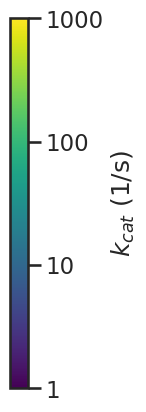

In [150]:
fig = plt.figure()
# add colorbar for kcat in bottom left of heatmap
sm = plt.cm.ScalarMappable(cmap=kcat_cmap, norm=kcat_normalize)
sm.set_array([])
# set color bar ticks
cbar = plt.colorbar(sm, label="$k_{cat}$ (1/s)")

cbar.set_ticks([0, 1, 2, 3])
    
ticks = cbar.get_ticks()
ticks = 10**ticks
cbar.set_ticklabels(ticks)

# hide axes
plt.gca().set_visible(False)



# hamming distance clustermap


In [121]:
hamming_arr = pairwise_distances(one_hot_kcat_df.to_numpy()[:,:-5], metric='hamming', n_jobs=4)

In [122]:
hamming_row_linkage = hierarchy.linkage(
    distance.pdist(hamming_arr), method='average')

hamming_col_linkage = hierarchy.linkage(
    distance.pdist(hamming_arr.T), method='average')

In [123]:
hamming_col_colors, hamming_col_color_dict = generate_col_colors(list(one_hot_kcat_df['lid_type']))
hamming_handles = [Patch(facecolor=hamming_col_color_dict[name]) for name in hamming_col_color_dict]


In [170]:

hamming_kcat_colors = [kcat_cmap(kcat_normalize(np.log10(value))) for value in one_hot_kcat_df["kcat_mean_normed"]]

Text(0.5, 1.0, 'One-hot MSA: Hamming Distance Clustermap')

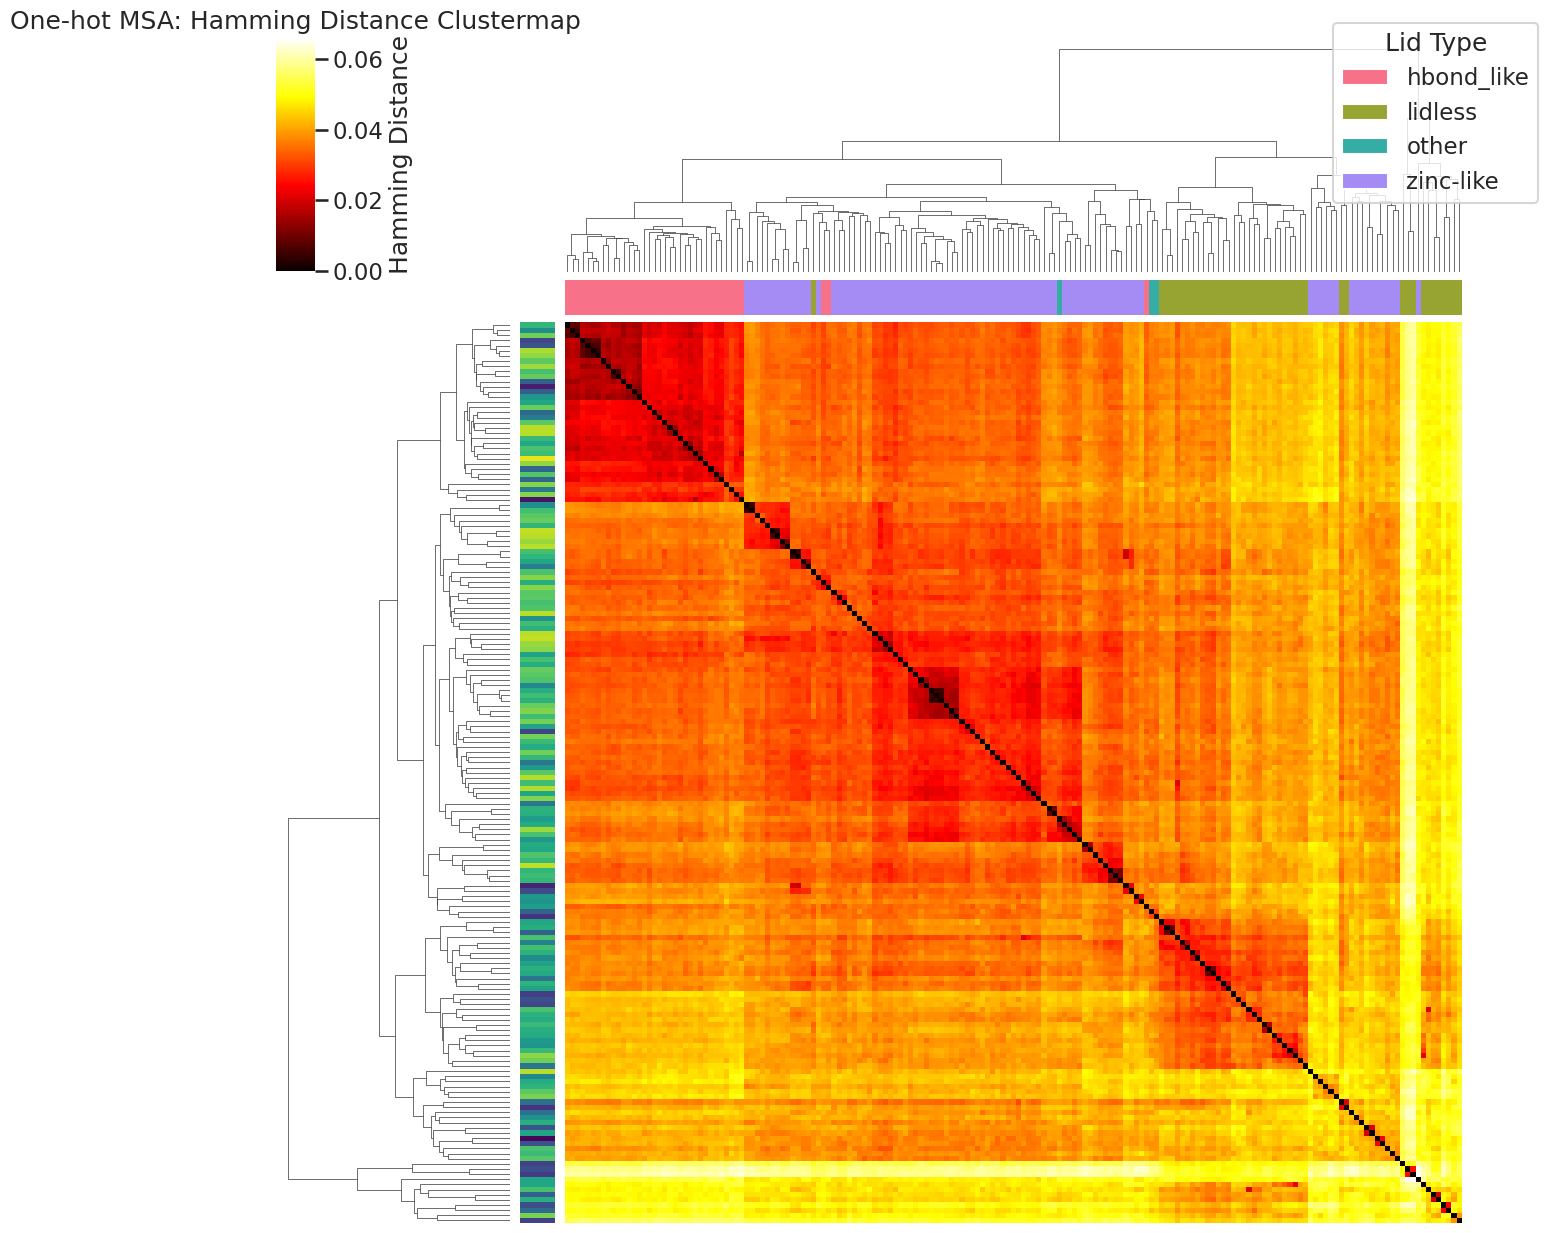

In [171]:
cg = sns.clustermap(
    hamming_arr,
    row_linkage=hamming_row_linkage, col_linkage=hamming_col_linkage,
    col_colors=hamming_col_colors,
    row_colors=hamming_kcat_colors,
     method="average", figsize=(13, 13),
     cmap="hot", cbar_pos=(0.02, 0.8, 0.03, 0.18), cbar_kws={"label": "Hamming Distance"})

# remove tick labels
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_yticklabels([])
# remove y ticks
cg.ax_heatmap.set_yticks([])

plt.legend(hamming_handles, hamming_col_color_dict, title='Lid Type',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.title("One-hot MSA: Hamming Distance Clustermap")

In [187]:
esm_clusters = hierarchy.fcluster(esm_row_linkage, t=30, criterion='maxclust')

In [188]:
print("ESM Hierarchical Clustering AMI: {:.2f}".format(adjusted_mutual_info_score(esm_clusters, esm_kcat_lid_type["lid_type"])))
print("ESM Hierarchical Clustering Shuffled AMI: {:.2f}".format(adjusted_mutual_info_score(esm_clusters, np.random.permutation(esm_kcat_lid_type["lid_type"]))))

ESM Hierarchical Clustering AMI: 0.17
ESM Hierarchical Clustering Shuffled AMI: 0.01


In [193]:
hamming_clusters = hierarchy.fcluster(hamming_row_linkage, t=30, criterion='maxclust')

In [194]:
hamming_cluster_col_colors, hamming_cluster_col_color_dict = generate_col_colors(hamming_clusters)
hamming_cluster_handles = [Patch(facecolor=hamming_cluster_col_color_dict[name]) for name in hamming_cluster_col_color_dict]

In [195]:
print("One-hot Hierarchical Clustering AMI: {:.2f}".format(adjusted_mutual_info_score(hamming_clusters, one_hot_kcat_df["lid_type"])))
print("One-hot Hierarchical Clustering Shuffled AMI: {:.2f}".format(adjusted_mutual_info_score(hamming_clusters, np.random.permutation(one_hot_kcat_df["lid_type"]))))

One-hot Hierarchical Clustering AMI: 0.47
One-hot Hierarchical Clustering Shuffled AMI: 0.01


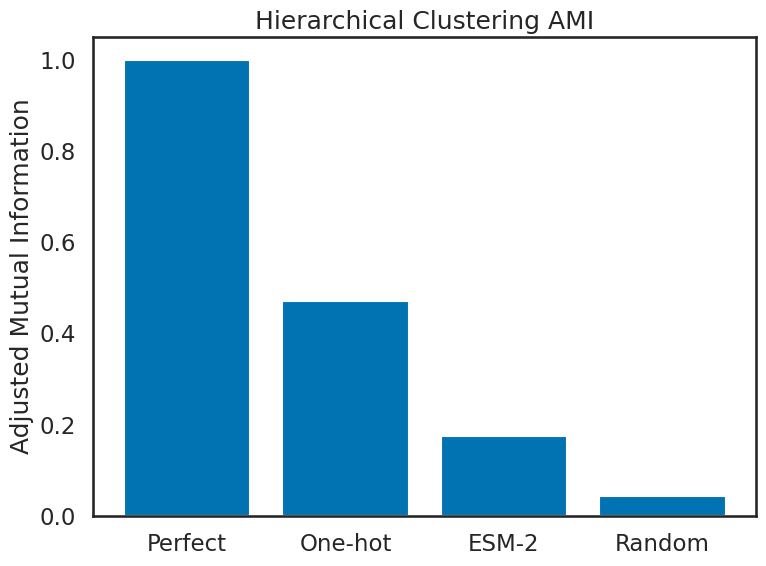

In [196]:
# barplot of AMI
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(["Perfect","One-hot", "ESM-2", "Random"], [adjusted_mutual_info_score(hamming_clusters, hamming_clusters),
                                        adjusted_mutual_info_score(hamming_clusters, one_hot_kcat_df["lid_type"]),
                              adjusted_mutual_info_score(esm_clusters, esm_kcat_lid_type["lid_type"]),
                              adjusted_mutual_info_score(hamming_clusters, np.random.permutation(one_hot_kcat_df["lid_type"]))])
ax.set_ylabel("Adjusted Mutual Information")
ax.set_title("Hierarchical Clustering AMI")
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
plt.savefig("../data/fig_pdfs/hierarchical_clustering_ami.pdf")

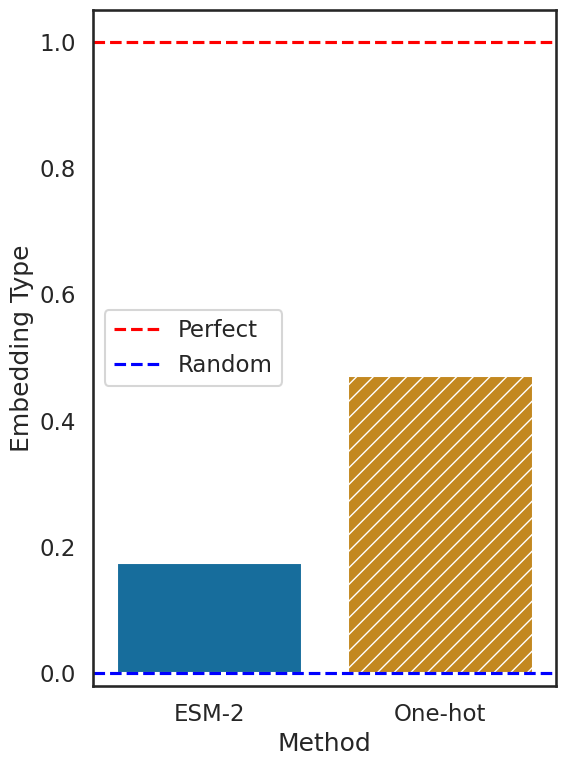

In [210]:
fig, ax = plt.subplots(figsize=(6, 8))

ami_df = pd.DataFrame({"Method": ["ESM-2","One-hot"],
"AMI": [
        adjusted_mutual_info_score(esm_clusters, esm_kcat_lid_type["lid_type"]),
        adjusted_mutual_info_score(hamming_clusters, one_hot_kcat_df["lid_type"]),
        ]})
sns.barplot(data=ami_df, x="Method", y="AMI", hue="Method", ax=ax, palette="colorblind")


ax.patches[-1].set_hatch("//")

ax.set_xlabel("Method")
ax.set_ylabel("Embedding Type")
ax.set_ylim(bottom=-.02, top=1.05)
ax.axhline(y=adjusted_mutual_info_score(hamming_clusters, hamming_clusters), color='r', linestyle='--', label="Perfect")
#ax.axhline(y=adjusted_mutual_info_score(hamming_clusters, np.random.permutation(one_hot_kcat_df["lid_type"])), color='b', linestyle='--', label="Random")
ax.axhline(y=0, color='b', linestyle='--', label="Random")

ax.legend()
plt.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("../data/fig_pdfs/hierarchical_clustering_ami_new.pdf")